# Comprehensive Financial Due Diligence Analysis - Tech Stock Portfolio

imports and helper functions

In [2]:
%pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     -------------------- ----------------- 524.3/949.2 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 949.2/949.2 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------------- -------------------- 0.8/1.6 MB 2.1 MB/s eta 0:00:01
   -------------------------------- ------- 1.3/

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires ml-dtypes<0.5.0,>=0.3.1, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
tensorflow-intel 2.17.0 requires tensorboard<2.18,>=2.17, but you have tensorboa

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

show plots inline when running as notebook

In [4]:
plt.rcParams['figure.figsize'] = (10,6)

Helper functions

In [5]:
def download_price_data(tickers, start, end, interval='1d'):
    data = yf.download(tickers, start=start, end=end, interval=interval, group_by='ticker', auto_adjust=True, progress=False)
    # Return adjusted close in a DataFrame (columns = tickers)
    if isinstance(tickers, list) and len(tickers) > 1:
        adj = pd.DataFrame({t: data[t]['Close'] for t in tickers})
    else:
        # single ticker
        if isinstance(tickers, list): t = tickers[0]
        else: t = tickers
        adj = pd.DataFrame({t: data['Close']})
    return adj

 # 1) Data Extraction & Collection
 - Real-time financial data extraction using Yahoo Finance (yfinance)
 - Financial statements and key metrics collection
 - Benchmark data (S&P 500)

Data Extraction & Collection

In [6]:
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']  # example tech universe
BENCHMARK = '^GSPC'  # S&P 500
END = datetime.today().date()
START = END - timedelta(days=365*3)  # 3 years history

prices = download_price_data(TICKERS + [BENCHMARK], start=START, end=END)
prices.head()

,AAPL,MSFT,GOOGL,AMZN,NVDA,^GSPC
Date,,,,,,
2022-09-19,152.079361,238.584900,102.363991,124.660004,13.365941,3899.889893
2022-09-20,154.461731,236.565155,100.447205,122.190002,13.160191,3855.929932
2022-09-21,151.331161,233.150085,98.599945,118.540001,13.245088,3789.929932
2022-09-22,150.366379,235.130783,99.454056,117.309998,12.545926,3757.989990
2022-09-23,148.092270,232.145096,98.063652,113.779999,12.500980,3693.229980


Fetch fundamentals & key metrics (using yfinance Ticker object)

In [7]:
fundamentals = {}
for t in TICKERS:
    tk = yf.Ticker(t)
    info = tk.info
    # select a subset of fields commonly used
    fundamentals[t] = {
        'marketCap': info.get('marketCap'),
        'trailingPE': info.get('trailingPE'),
        'priceToBook': info.get('priceToBook'),
        'debtToEquity': info.get('debtToEquity'),
        'returnOnEquity': info.get('returnOnEquity'),
        'beta': info.get('beta')
    }
fund_df = pd.DataFrame(fundamentals).T
fund_df

,marketCap,trailingPE,priceToBook,debtToEquity,returnOnEquity,beta
AAPL,3.534241e+12,36.083332,53.746330,154.486,1.49814,1.109
MSFT,3.783781e+12,37.319650,11.017228,32.661,0.33281,1.040
GOOGL,3.038936e+12,26.804697,8.376747,11.481,0.34829,1.011
AMZN,2.496120e+12,35.732822,7.475009,47.808,0.24770,1.309
NVDA,4.257804e+12,49.681820,42.518845,10.584,1.09417,2.102


# 2) Data Preprocessing & Feature Engineering
 - Technical indicators (RSI, Bollinger Bands, Moving Averages)
 - ML features: lagged returns, volatility measures
 - Normalization

Preprocessing & Feature Engineering

In [8]:
def compute_technical_indicators(df):
    out = pd.DataFrame(index=df.index)
    out['close'] = df
    # returns
    out['return'] = df.pct_change()
    # moving averages
    out['ma_20'] = df.rolling(20).mean()
    out['ma_50'] = df.rolling(50).mean()
    # Bollinger Bands
    rolling_std = df.rolling(20).std()
    out['bb_upper'] = out['ma_20'] + 2*rolling_std
    out['bb_lower'] = out['ma_20'] - 2*rolling_std
    # RSI
    delta = df.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.ewm(span=14).mean()
    roll_down = down.ewm(span=14).mean()
    rs = roll_up / roll_down
    out['rsi_14'] = 100.0 - (100.0 / (1.0 + rs))
    # volatility (rolling)
    out['vol_20'] = df.pct_change().rolling(20).std() * np.sqrt(252)
    return out

create features for each ticker and store

In [9]:
features = {}
for t in TICKERS:
    s = prices[t]
    feats = compute_technical_indicators(s)
    # lagged returns and momentum
    feats['ret_1'] = feats['return'].shift(1)
    feats['ret_5'] = feats['return'].shift(5)
    feats['vol_5'] = s.pct_change().rolling(5).std()
    features[t] = feats.dropna()


Example: show features for AAPL

In [10]:
features['AAPL'].tail()

,close,return,ma_20,ma_50,bb_upper,bb_lower,rsi_14,vol_20,ret_1,ret_5,vol_5
Date,,,,,,,,,,,
2025-09-08,237.880005,-0.007551,231.592499,219.007781,240.419802,222.765195,67.376142,0.194082,-0.000375,-0.001806,0.019491
2025-09-09,234.350006,-0.014839,231.950999,219.677740,240.604436,223.297563,54.196790,0.199939,-0.007551,-0.010425,0.020443
2025-09-10,226.789993,-0.032259,231.807999,220.114792,240.712424,222.903575,36.536146,0.229872,-0.014839,0.038090,0.014642
2025-09-11,230.029999,0.014286,231.642999,220.563703,240.550973,222.735026,45.343508,0.228289,-0.032259,0.005493,0.017250
2025-09-12,234.070007,0.017563,231.707500,221.001120,240.668660,222.746340,54.440238,0.237054,0.014286,-0.000375,0.020776


# 3) Exploratory Data Analysis (EDA)
- Price performance visualizations
- Risk-return profile and correlations


Price chart for tickers

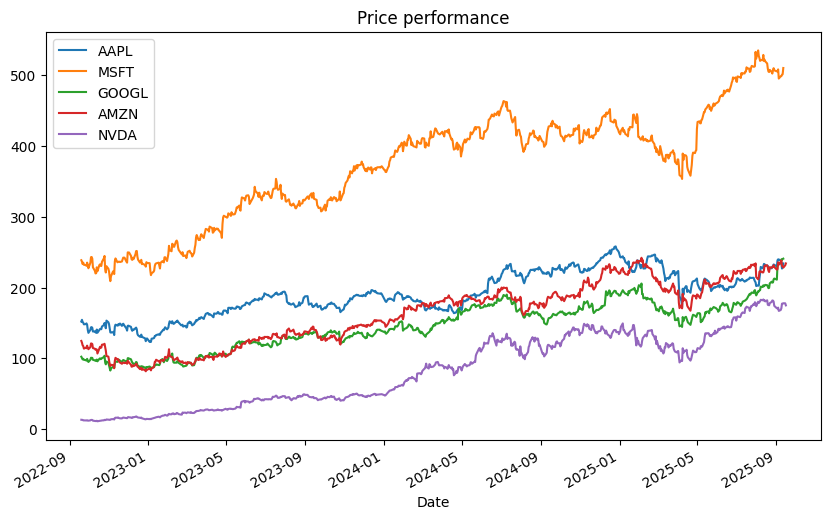

In [11]:
prices[TICKERS].plot(subplots=False, title='Price performance');

compute daily returns and show risk-return

In [12]:
returns = prices[TICKERS].pct_change().dropna()
mean_returns = returns.mean()*252
volatility = returns.std()*np.sqrt(252)
rr = pd.DataFrame({'ann_return': mean_returns, 'ann_vol': volatility})
rr

,ann_return,ann_vol
AAPL,0.189193,0.278694
MSFT,0.287000,0.254794
GOOGL,0.351495,0.315673
AMZN,0.268975,0.339215
NVDA,0.999987,0.523308


scatter risk-return

Text(0.5, 1.0, 'Risk-Return')

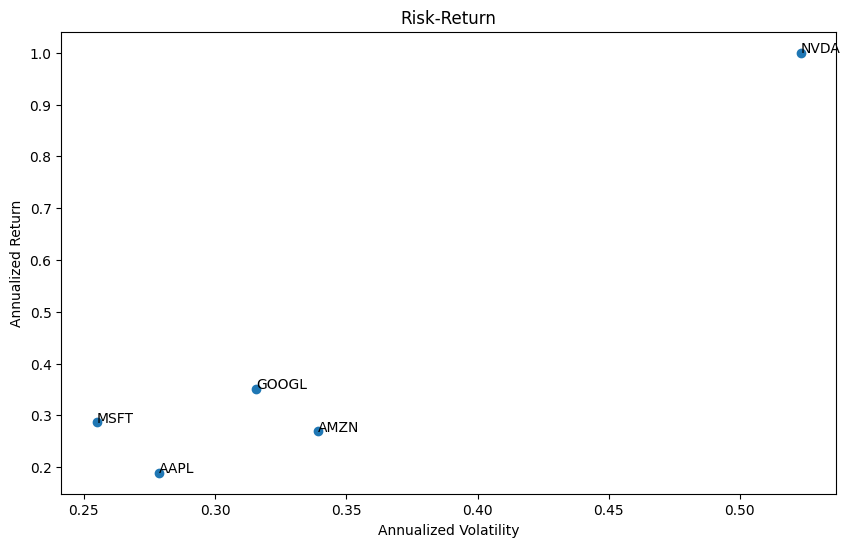

In [13]:
plt.figure();
plt.scatter(rr['ann_vol'], rr['ann_return'])
for i, txt in enumerate(rr.index):
    plt.annotate(txt, (rr['ann_vol'][i], rr['ann_return'][i]))
plt.xlabel('Annualized Volatility'); plt.ylabel('Annualized Return'); plt.title('Risk-Return')

Correlation heatmap

Text(0.5, 1.0, 'Return Correlation Matrix')

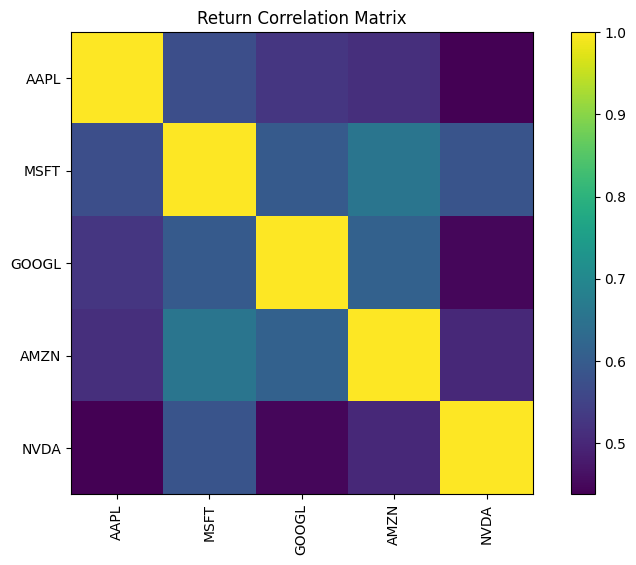

In [14]:
corr = returns.corr()
plt.figure();
plt.imshow(corr, interpolation='none'); plt.colorbar();
plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.columns);
plt.title('Return Correlation Matrix')

# 4) Fundamental Analysis
- Extract P/E, P/B, ROE, ROA, Debt/Equity
- Build simple financial health score

Fundamental Analysis

In [15]:
fund_df['pe_z'] = (fund_df['trailingPE'] - fund_df['trailingPE'].mean()) / fund_df['trailingPE'].std()
fund_df['pb_z'] = (fund_df['priceToBook'] - fund_df['priceToBook'].mean()) / fund_df['priceToBook'].std()
fund_df['de_z'] = (fund_df['debtToEquity'] - fund_df['debtToEquity'].mean()) / fund_df['debtToEquity'].std()
# simple score: lower PE/PB + lower DE + higher ROE => better
fund_df['health_score'] = (-fund_df['pe_z'] - fund_df['pb_z'] - fund_df['de_z'] + (fund_df['returnOnEquity'].fillna(0)))
fund_df = fund_df.sort_values('health_score', ascending=False)
fund_df[['marketCap','trailingPE','priceToBook','debtToEquity','returnOnEquity','beta','health_score']]

,marketCap,trailingPE,priceToBook,debtToEquity,returnOnEquity,beta,health_score
GOOGL,3.038936e+12,26.804697,8.376747,11.481,0.34829,1.011,3.023055
AMZN,2.496120e+12,35.732822,7.475009,47.808,0.24770,1.309,1.262804
MSFT,3.783781e+12,37.319650,11.017228,32.661,0.33281,1.040,1.245514
NVDA,4.257804e+12,49.681820,42.518845,10.584,1.09417,2.102,-0.576686
AAPL,3.534241e+12,36.083332,53.746330,154.486,1.49814,1.109,-1.433577


# 5) Risk Analysis & Portfolio Optimization
 - MPT: estimate efficient frontier (simplified)
 - VaR & CVaR
 - Beta and CAPM

compute covariance and expected returns

In [16]:
mu = returns.mean() * 252
Sigma = returns.cov() * 252

functions for portfolio performance

In [17]:
def portfolio_perf(weights, mu, Sigma):
    w = np.array(weights)
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    sharpe = ret / vol if vol>0 else 0
    return ret, vol, sharpe

objective: maximize sharpe (minimize negative sharpe)

In [18]:
def neg_sharpe(weights, mu, Sigma):
    return -portfolio_perf(weights, mu, Sigma)[2]

constraints

In [19]:
n = len(TICKERS)
bounds = tuple((0,1) for _ in range(n))
cons = ({'type':'eq','fun': lambda x: np.sum(x)-1})
init = np.array([1/n]*n)

res = minimize(neg_sharpe, init, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)
opt_weights = pd.Series(res.x, index=TICKERS)
opt_weights

AAPL     0.000000e+00
MSFT     0.000000e+00
GOOGL    2.337085e-01
AMZN     1.281801e-17
NVDA     7.662915e-01
dtype: float64

VaR (historical) for portfolio

In [20]:
port_returns = returns.dot(opt_weights)
var_95 = np.percentile(port_returns.dropna(), 5)
cvar_95 = port_returns[port_returns <= var_95].mean()
var_95, cvar_95

(-0.038365387462335754, -0.055810950622868734)

Beta against S&P 500

In [21]:
bench_returns = prices[BENCHMARK].pct_change().dropna()
betas = {}
for t in TICKERS:
    joined = pd.concat([returns[t], bench_returns], axis=1).dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(joined.iloc[:,1], joined.iloc[:,0])
    betas[t] = slope
pd.Series(betas)

AAPL     1.238342
MSFT     1.129427
GOOGL    1.204948
AMZN     1.455598
NVDA     2.133619
dtype: float64

# 6) Machine Learning Models
- Train models for next-day return prediction (regression) and direction (classification)
- Compare models

Machine Learning Models (example: predict sign of next-day return for AAPL)

In [22]:
sym = 'AAPL'
df = features[sym].copy()
# label: next day return sign
df['target_ret'] = df['return'].shift(-1)
df['target_sign'] = (df['target_ret'] > 0).astype(int)
df = df.dropna()

X = df[['ma_20','ma_50','bb_upper','bb_lower','rsi_14','vol_20','ret_1','ret_5','vol_5']]
y_reg = df['target_ret']
y_clf = df['target_sign']

In [23]:
# scale features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# time series split
tscv = TimeSeriesSplit(n_splits=5)

# regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg_scores = cross_val_score(rf_reg, Xs, y_reg, scoring='neg_mean_squared_error', cv=tscv)
np.sqrt(-reg_scores)

# classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_scores = cross_val_score(rf_clf, Xs, y_clf, scoring='accuracy', cv=tscv)
clf_scores

# train final classifier and feature importance
rf_clf.fit(Xs, y_clf)
importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances


vol_5       0.130496
ret_5       0.129720
rsi_14      0.114771
ret_1       0.114384
vol_20      0.110167
bb_lower    0.102930
bb_upper    0.099316
ma_50       0.099288
ma_20       0.098928
dtype: float64

# 7) Investment Recommendation System
 - Combine multi-factor scoring: valuation, growth (ROE), risk (beta), momentum (past returns)
 - Produce buy/sell/hold

Investment Recommendation System

In [24]:
momentum = (prices[TICKERS].pct_change(90).iloc[-1])  # 3-month momentum
score_df = pd.DataFrame(index=TICKERS)
score_df['health_score'] = fund_df['health_score']
score_df['beta'] = pd.Series(betas)
score_df['momentum_90'] = momentum
# normalize each feature
for col in score_df.columns:
    score_df[col + '_z'] = (score_df[col] - score_df[col].mean())/score_df[col].std()
# higher health_score_z and momentum positive, lower beta is better
score_df['composite'] = score_df['health_score_z'] + score_df['momentum_90_z'] - score_df['beta_z']
score_df = score_df.sort_values('composite', ascending=False)

# simple rule: top 20% -> buy, middle 60% -> hold, bottom 20% -> sell
n = len(score_df)
buy_cut = int(0.2*n) if n>5 else 1
sell_cut = int(0.2*n)
score_df['recommendation'] = 'hold'
score_df.iloc[:buy_cut, score_df.columns.get_loc('recommendation')] = 'buy'
score_df.iloc[-sell_cut:, score_df.columns.get_loc('recommendation')] = 'sell'
score_df[['composite','recommendation']]

,composite,recommendation
GOOGL,3.327053,buy
MSFT,0.194995,hold
AMZN,-0.297915,hold
AAPL,-1.425799,hold
NVDA,-1.798334,sell


# 8) Portfolio Backtesting
 - Backtest optimized portfolio vs benchmark

Backtesting

{'portfolio_cagr': 0.7869152640017019,
 'benchmark_cagr': 0.1934936871704438,
 'portfolio_sharpe': 1.4312045323751506,
 'portfolio_max_drawdown': -0.33756683612839394}

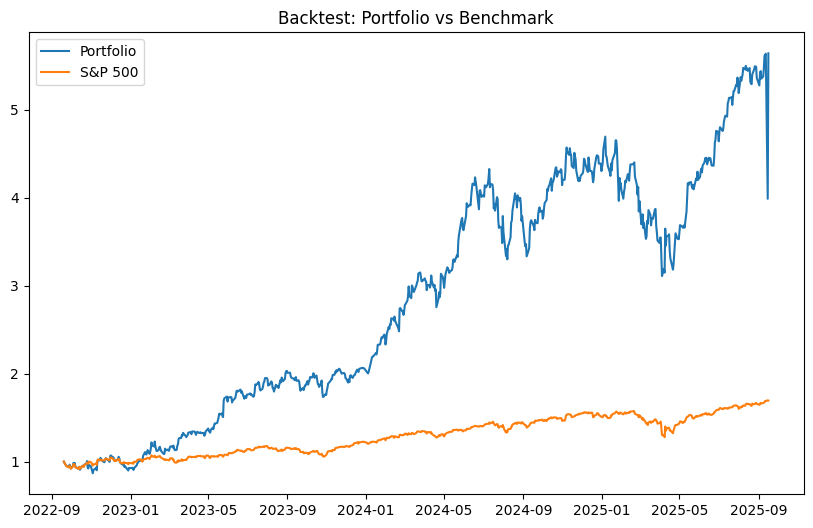

In [25]:
weights = opt_weights
portfolio_price = (prices[TICKERS] * weights).sum(axis=1)
portfolio_returns = portfolio_price.pct_change().fillna(0)
portfolio_cum = (1+portfolio_returns).cumprod()
benchmark_cum = (1 + prices[BENCHMARK].pct_change().fillna(0)).cumprod()

plt.figure();
plt.plot(portfolio_cum.index, portfolio_cum, label='Portfolio')
plt.plot(benchmark_cum.index, benchmark_cum, label='S&P 500')
plt.legend(); plt.title('Backtest: Portfolio vs Benchmark')

# drawdown
running_max = portfolio_cum.cummax()
drawdown = (portfolio_cum - running_max) / running_max
max_drawdown = drawdown.min()
max_drawdown

# performance summary
perf = {
    'portfolio_cagr': (portfolio_cum.iloc[-1])**(252/len(portfolio_cum)) - 1,
    'benchmark_cagr': (benchmark_cum.iloc[-1])**(252/len(benchmark_cum)) - 1,
    'portfolio_sharpe': portfolio_returns.mean()/portfolio_returns.std()*np.sqrt(252),
    'portfolio_max_drawdown': max_drawdown
}
perf

# 9) Executive Summary & Reporting
- Produce a concise markdown report and save key tables as CSV

Executive Summary & Reporting

In [26]:
report = {
    'date': str(datetime.today().date()),
    'universe': TICKERS,
    'opt_weights': opt_weights.to_dict(),
    'top_recommendations': score_df[score_df['recommendation']=='buy'].index.tolist(),
    'portfolio_performance': perf
}

# save outputs
fund_df.to_csv('fundamentals_summary.csv')
score_df.to_csv('recommendation_scores.csv')
opt_weights.to_csv('optimal_weights.csv')

# Print brief summary
print('Executive Summary (dict):')
for k,v in report.items():
    print(k, ':', v)

Executive Summary (dict):
date : 2025-09-17
universe : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
opt_weights : {'AAPL': 0.0, 'MSFT': 0.0, 'GOOGL': 0.23370851763340414, 'AMZN': 1.281801182667147e-17, 'NVDA': 0.7662914823665958}
top_recommendations : ['GOOGL']
portfolio_performance : {'portfolio_cagr': 0.7869152640017019, 'benchmark_cagr': 0.1934936871704438, 'portfolio_sharpe': 1.4312045323751506, 'portfolio_max_drawdown': -0.33756683612839394}
